<a href="https://colab.research.google.com/github/zhouchun0105/Fake-News-Detection-Project-BA865/blob/main/BA865_Fake_News_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [20]:
# imports 
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

In [2]:
# Mounting Google Drive locally
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Setup and Data Cleaning

In [14]:
# Import data 
df_fakenews_true = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/True.csv")
df_fakenews_fake = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/Fake.csv")


In [25]:
df_fakenews_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [16]:
df_fakenews_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [18]:
df_fakenews_true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [19]:
df_fakenews_fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [26]:
df_fakenews_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [28]:
df_fakenews_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [32]:
print(df_fakenews_true.shape)
print(df_fakenews_fake.shape)

(21417, 4)
(23481, 4)


In [33]:
# checking for any null values
df_fakenews_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [34]:
# checking for any null values
df_fakenews_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

# Data Pre-Processing

In [35]:
# creating new colum 'Real/Fake', labeling the two datasets in order to merge and know which observation is real and which one is false
df_fakenews_true['real/fake'] = '1'
df_fakenews_fake['real/fake'] = '0'

In [37]:
# merging the two datasets
frames = [df_fakenews_true, df_fakenews_fake]
news_data = pd.concat(frames)
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   Real/Fake  44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [40]:
news_data.head()

,title,text,subject,date,Real/Fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
# date column Split to see if there are seasonal trends

In [ ]:
# one-hot encoding for subject column



In [ ]:
# title and text can be two seperate variables

# EDA

(-0.5, 1299.5, 949.5, -0.5)

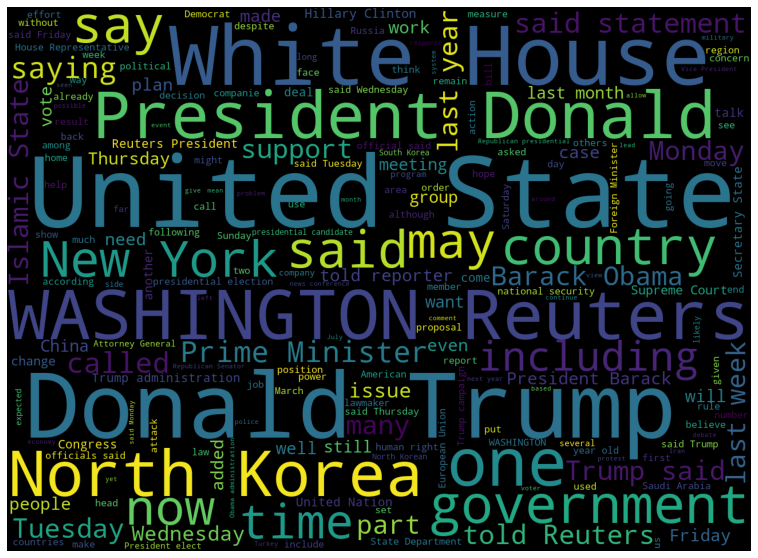

In [22]:
# word cloud for the text real true News
text_true = pd.Series(df_fakenews_true['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_true.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 1299.5, 949.5, -0.5)

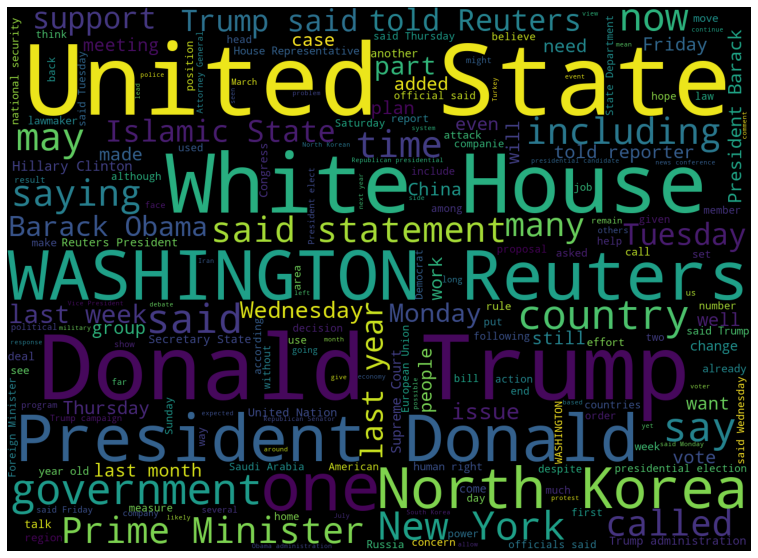

In [23]:
# word cloud for the text false fake News
text_false = pd.Series(df_fakenews_true['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_false.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

# Feature Engineering/Natural Language Processing 


*   TfiDf Vectorizer
*   SpaCy
*   Work Tokenizer



# Deep Learning/Tenserflow